## Coding Assignment
<i>Q: Write a python class with different function to fit LDA model, evaluate optimal number of topics based on best coherence scores and predict new instances based on best LDA model with optimal number of topics based on best coherence score. Function should take 2darray of embeddings as input and return a LDA model, optimal number of topics and topics.</i>

In [ ]:
"""
author: Parikshit Saikia
email: pariksihtsaikia1619@gmail.com
github: https://github.com/parikshitsaikia1619
date: 20-08-2021
"""

### Step 1: Import neccessary Libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

import spacy
from tqdm.notebook import tqdm
#spacy download en_core_web_sm

In [3]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

[nltk_data] Downloading package stopwords to C:\Users\Parikshit
[nltk_data]     Saikia\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Step 2: Load the dataset
This dataset contains a set of research articles related to computer science, mathematics, physics and statistics. Each article is tagged into major and minor topics in the form one hot encoding.<br>
But for our task (topic modeling) we don't need the tags, we just need the articles text.<br>
From the dataset we will form a list of articles<br>

In [4]:
data = pd.read_csv('./data/research_articles/Train.csv/Processed_train.csv')

In [5]:
data.head()

,ABSTRACT,Major_topics,Minor_topics
0,a ever-growing datasets inside observational a...,"[0, 0, 1, 0]","[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, ..."
1,we propose the framework considering optimal $...,"[1, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ..."
2,nanostructures with open shell transition meta...,"[0, 0, 1, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,stars are self-gravitating fluids inside which...,"[0, 0, 1, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ..."
4,deep neural perception and control networks ar...,"[1, 0, 0, 0]","[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, ..."


In [6]:
articles_data = data.ABSTRACT.values.tolist()

### Step 3: Creating a Data Preprocessing Pipeline

This is the most important step in this entire code . We cannot expect good results from a model trained on a uncleaned data.<br>
As the famous quote goes <i>"garbage in,garbage out"</i><br>
We want our corpus consisting a list of representative words capturing the essence of each article, To achieve that we need to follow a sequence of steps:<br>
![nlp_preprocessing](./image.png)
<br>

In [7]:
def convert_lowercase(string_list):
    """
    Convert the list of strings to lowercase and returns the list
    """
    pbar = tqdm(total = len(string_list),desc='lowercase conversion progress')
    for i in range(len(string_list)):
        string_list[i] = string_list[i].lower()
        pbar.update(1)
    pbar.close()
    return string_list

def remove_punctuation(doc_list):
    """
    Tokenization and remove punctuation and return the list of tokens
    """
    doc_word_list = []
    pbar = tqdm(total = len(doc_list),desc='punctuation removal progress')
    for doc in doc_list:
        doc_word_list.append(gensim.utils.simple_preprocess(str(doc), deacc=True,min_len=4))  # deacc=True removes punctuations
        pbar.update(1)
    pbar.close()
    return doc_word_list

def remove_stopwords(texts):
    """
    Remove common occuring words from the list of tokens
    stop words : a,an ,the ,so ,from ...
    
    """
    docs_data=[]
    stop_words = stopwords.words('english')
    pbar = tqdm(total = len(texts),desc='stopword removal progress')
    for doc in texts:
        doc_data=[]
        for word in doc:
            if word not in stop_words:
                doc_data.append(word)
        docs_data.append(doc_data)
        pbar.update(1)
    pbar.close()
    return docs_data

def filter_word_len(texts,size):
    """
    Remove tokens if their length is smaller than threshold
    
    """
    docs_data=[]
    pbar = tqdm(total = len(texts),desc='word filtering progress')
    for doc in texts:
        doc_data=[]
        for word in doc:
            if len(word)>=size:
                doc_data.append(word)
        docs_data.append(doc_data)
        pbar.update(1)
    pbar.close()
    return docs_data

def make_bigrams(texts):
    """
    Combine words that are frequently occurs together
    eg: Good Person , Great Content , Ever Growing
    """
    # Build the bigram and models
    pbar = tqdm(total = len(texts),desc='Bigram progress')
    
    bigram = gensim.models.Phrases(texts, min_count=5, threshold=100) # higher threshold fewer phrases.
    bigram_mod = gensim.models.phrases.Phraser(bigram)
    
    pbar.update(len(texts))
    pbar.close()
    return [bigram_mod[doc] for doc in texts]


def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """
    Only allows token which are noun,adjective,verb and adverb.
    Also converting the tokens into base form
    """
    nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
    texts_out = []
    pbar = tqdm(total = len(texts),desc='lemmatization progress')
    
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
        pbar.update(1)
    pbar.close()
    
    return texts_out

def preprocessing_pipeline(doc_list,size):
    """
    Converting each document into list of tokens that represents the document
    """
    doc_list = convert_lowercase(doc_list)
    doc_data_words = remove_punctuation(doc_list)
    # Remove Stop Words
    data_words_nostops = remove_stopwords(doc_data_words)
    
     # Form Bigrams
    data_words_bigrams = make_bigrams(data_words_nostops)

    data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
    
    final_data_words = filter_word_len(data_lemmatized,size)
        
    return final_data_words
    
def corpus_embeddings(data):
    """
    Converting each token in each document into a tuple of (unique id, frequency of occuring in that document)
    """
    # Create Dictionary
    id2word = corpora.Dictionary(data)
    # Create Corpus
    texts = data
    # Term Document Frequency
    corpus = [id2word.doc2bow(text) for text in texts]
    
    return corpus,id2word
    

In [8]:
processed_data = preprocessing_pipeline(articles_data,4) # this will take some time

lowercase conversion progress:   0%|          | 0/14004 [00:00<?, ?it/s]

punctuation removal progress:   0%|          | 0/14004 [00:00<?, ?it/s]

stopword removal progress:   0%|          | 0/14004 [00:00<?, ?it/s]

Bigram progress:   0%|          | 0/14004 [00:00<?, ?it/s]

lemmatization progress:   0%|          | 0/14004 [00:00<?, ?it/s]

word filtering progress:   0%|          | 0/14004 [00:00<?, ?it/s]

In [19]:
processed_data[0]

['ever_growe',
 'dataset',
 'observational',
 'astronomy',
 'challenge',
 'scientist',
 'many',
 'aspect',
 'include',
 'efficient',
 'interactive',
 'datum',
 'exploration',
 'visualization',
 'many',
 'tool',
 'develop',
 'confront',
 'challenge',
 'however',
 'usually',
 'focus',
 'display',
 'actual',
 'image',
 'focus',
 'visualizing',
 'pattern',
 'catalog',
 'predefine',
 'paper',
 'introduce',
 'vizic',
 'visualization',
 'library',
 'build',
 'connection',
 'image',
 'catalog',
 'interactive',
 'region',
 'vizic',
 'visualize',
 'catalog',
 'datum',
 'custom',
 'background',
 'canvas',
 'help',
 'shape',
 'size',
 'orientation',
 'object',
 'catalog',
 'display',
 'object',
 'highly',
 'interactive',
 'customizable',
 'compare',
 'image',
 'object',
 'filter',
 'colored',
 'property',
 'redshift',
 'also',
 'select',
 'help',
 'lasso',
 'tool',
 'consider',
 'analysis',
 'help',
 'standard',
 'function',
 'jupyter',
 'notebook',
 'furthermore',
 'vizic',
 'allow',
 'custom',
 

### Step 4: Finalizing the input data
In this step we will form our the inputs of model, which are:<br>
* **Corpus**: A 2D embedded array of tuples, where each tuple is in the form of (token id, frequency of token in that document).
* **dictionary**: A dictionary storing the mapping from token to id.

In [20]:
new_corpus,id_word = corpus_embeddings(processed_data)

In [21]:
new_corpus

[[(0, 1),
  (1, 1),
  (2, 1),
  (3, 2),
  (4, 1),
  (5, 3),
  (6, 1),
  (7, 1),
  (8, 1),
  (9, 1),
  (10, 1),
  (11, 1),
  (12, 1),
  (13, 5),
  (14, 2),
  (15, 1),
  (16, 1),
  (17, 1),
  (18, 1),
  (19, 1),
  (20, 1),
  (21, 3),
  (22, 1),
  (23, 3),
  (24, 1),
  (25, 1),
  (26, 1),
  (27, 1),
  (28, 4),
  (29, 1),
  (30, 2),
  (31, 3),
  (32, 1),
  (33, 1),
  (34, 1),
  (35, 1),
  (36, 1),
  (37, 1),
  (38, 1),
  (39, 1),
  (40, 2),
  (41, 1),
  (42, 1),
  (43, 1),
  (44, 2),
  (45, 1),
  (46, 1),
  (47, 3),
  (48, 1),
  (49, 1),
  (50, 1),
  (51, 1),
  (52, 3),
  (53, 1),
  (54, 1),
  (55, 1),
  (56, 1),
  (57, 5),
  (58, 1),
  (59, 1),
  (60, 1),
  (61, 1),
  (62, 1),
  (63, 2),
  (64, 1),
  (65, 1),
  (66, 1),
  (67, 1),
  (68, 1),
  (69, 2),
  (70, 1),
  (71, 2),
  (72, 3),
  (73, 1),
  (74, 1),
  (75, 1),
  (76, 3),
  (77, 1),
  (78, 1),
  (79, 1),
  (80, 1),
  (81, 1),
  (82, 1),
  (83, 1),
  (84, 1),
  (85, 1),
  (86, 1),
  (87, 1),
  (88, 2),
  (89, 1),
  (90, 1),
  (91, 2)

In [ ]:
id_word[0]

In [10]:
word_freq = [[(id_word[id], freq) for id, freq in cp] for cp in new_corpus[:1]]

In [ ]:
word_freq # A more human reable form of our corpus

### Step 5: Modeling and Evaluation
In this part we will fit our data to our the LDA model , some hyper parameter tuning , evaluate the results and select the optimal setting for our model.

In [12]:
class LDA_model:
    """
    A LDA Class consist functions to fit the model, calculating coherence values
    and finding the optimal no. of topic
    
    input: 
     corpus : a 2D array of embedded tokens
     dictionary: A dictionary with id to token mapping
     
    """
    def __init__(self, corpus,dictionary):
        self.corpus = corpus
        self.dictionary = dictionary
    
    def LDA(self,no_topics, a ='auto', b = 'auto',passes=10):
        lda_model = gensim.models.ldamodel.LdaModel(corpus=self.corpus, id2word=self.dictionary,
                                                    num_topics=no_topics, random_state=100,chunksize=100,passes=passes,alpha=a,eta=b)
        return lda_model

    def compute_coherence_values(self,processed_data,no_topics,a ='auto', b = 'auto',passes=10):
        """
        Computes the coherence value of a fitted LDA model
        """
    
        pbar = tqdm(total = len(self.corpus),desc='LDA with '+str(no_topics)+' topics')
        
        lda_model = self.LDA(no_topics,a,b,passes)
        pbar.update(len(self.corpus)/2)
        coherence_model_lda = CoherenceModel(model=lda_model, texts=processed_data, dictionary=self.dictionary, coherence='c_v')
        pbar.update(len(self.corpus) -(len(self.corpus)/2))
        pbar.close()

        return coherence_model_lda.get_coherence()

    def compute_optimal_topics(self,processed_data,min_topics,max_topics,step_size,path):
        """
        Calucates the coherence value for a given range of topic size and forms a dataset
        """
        
        topics_range = list(np.arange(min_topics,max_topics,step_size))
        model_results = {'Topics': [],'Coherence': []}
        # Can take a long time to run
        for i in range(len(topics_range)):
            # get the coherence score for the given parameters
            cv = self.compute_coherence_values(processed_data,topics_range[i],a ='auto', b = 'auto',passes=10)
            # Save the model results
            model_results['Topics'].append(topics_range[i])
            model_results['Coherence'].append(cv)
        pd.DataFrame(model_results).to_csv(path, index=False)
    
    def Optimal_no_topics(self,path):
        """
        finds the topic size with max coherence score
        """
        coherence_data = pd.read_csv(path)
        x = coherence_data.Topics.tolist()
        y = coherence_data.Coherence.tolist()
        plt.xlabel('No. of topics')
        plt.ylabel('Coherence Score')
        plt.plot(x,y)
        plt.show()
        index = np.argmax(y)
        no_topics = x[index]
        c_v = y[index]
        print('Optimal number of topics: '+str(no_topics)+' coherence score: '+str(c_v))
        
        return no_topics,c_v
    
    def Optimal_lda_model(self,path):
        """
        Fits the LDA with optimal topic size
        """
        no_topic, c_v =  self.Optimal_no_topics(path)
        pbar = tqdm(total = len(self.corpus),desc='LDA with '+str(no_topic)+' topics')
        lda = self.LDA(no_topic)
        pbar.update(len(self.corpus))
        pbar.close()
        
        return lda
        

In [13]:
lda_model = LDA_model(new_corpus,id_word)

In [15]:
path = './dat.csv'

**Note**: Computing the optimal number of topics for LDA will take a pretty long amount of time<br>
The time complexity of this process : **O( m * x * p)**<br>
where:<br>
* m = no. of tokens in the corpus
* x = summation of no. of topics given in the range
* p = no. of passes for LDA model

In [16]:
lda_model.compute_optimal_topics(processed_data,2,4,1,path)

LDA with 2 topics:   0%|          | 0/14004 [00:00<?, ?it/s]

LDA with 3 topics:   0%|          | 0/14004 [00:00<?, ?it/s]

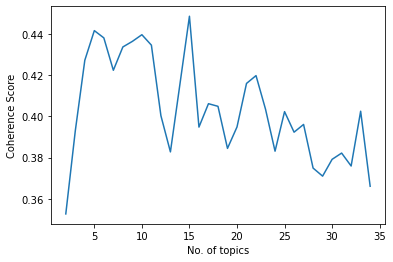

Optimal number of topics: 15 coherence score: 0.448488309


LDA with 15 topics:   0%|          | 0/14004 [00:00<?, ?it/s]

In [17]:
lda = lda_model.Optimal_lda_model('./results/lda_tuning_results1.csv')

In [18]:
lda.print_topics()

[(0,
  '0.114*"target" + 0.104*"sentence" + 0.071*"domain" + 0.064*"play" + 0.049*"programming" + 0.049*"similarity" + 0.048*"advanced" + 0.040*"teacher" + 0.034*"adapt" + 0.030*"safety"'),
 (1,
  '0.089*"robot" + 0.089*"environment" + 0.071*"user" + 0.047*"agent" + 0.044*"policy" + 0.043*"action" + 0.037*"human" + 0.023*"activity" + 0.022*"game" + 0.020*"robotic"'),
 (2,
  '0.044*"model" + 0.035*"consider" + 0.034*"method" + 0.025*"base" + 0.020*"system" + 0.016*"propose" + 0.015*"help" + 0.011*"present" + 0.011*"framework" + 0.010*"different"'),
 (3,
  '0.073*"surface" + 0.063*"flow" + 0.062*"geometry" + 0.052*"particle" + 0.036*"motion" + 0.034*"spectral" + 0.032*"angle" + 0.024*"force" + 0.022*"body" + 0.020*"plane"'),
 (4,
  '0.119*"code" + 0.076*"platform" + 0.056*"filter" + 0.052*"rule" + 0.050*"feedback" + 0.039*"assess" + 0.035*"particularly" + 0.031*"recurrent_neural" + 0.028*"kernel" + 0.026*"forecasting"'),
 (5,
  '0.096*"consider" + 0.025*"result" + 0.023*"show" + 0.020*"f

### Step 6: Visualization

In [22]:
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()

In [23]:
vis =  gensimvis.prepare(lda, new_corpus, id_word)
vis

D:\Anaconda\envs\parixit\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.279920 -0.032228       1        1  26.446803
5     -0.243441  0.180941       2        1  22.790238
10    -0.221810  0.190892       3        1  11.454349
13    -0.128062 -0.243736       4        1   9.594060
8     -0.129432 -0.194939       5        1   8.754389
9     -0.105471 -0.165489       6        1   5.176163
11    -0.060868  0.200462       7        1   4.430160
12    -0.013908  0.049471       8        1   3.170034
1      0.062959 -0.115848       9        1   2.038131
3      0.125676  0.034310      10        1   1.928456
6      0.182872  0.010498      11        1   1.140590
14     0.196190  0.011995      12        1   0.981773
4      0.210303  0.021459      13        1   0.788678
7      0.201485  0.033932      14        1   0.680777
0      0.203426  0.018280      15        1   0.625400, topic_info=                  Term          Freq         Total Category  logprob  loglift
21            consider  37299.000000  37299.000000  Default  30.0000  30.0000
148            problem   9109.000000   9109.000000  Default  29.0000  29.0000
303              model  15709.000000  15709.000000  Default  28.0000  28.0000
363            network   6950.000000   6950.000000  Default  27.0000  27.0000
28               datum   8374.000000   8374.000000  Default  26.0000  26.0000
...                ...           ...           ...      ...      ...      ...
3868              item      0.060490      1.162632  Topic15 -11.7112   2.1186
2932         heuristic      0.060490      1.164241  Topic15 -11.7112   2.1172
3629  natural_language      0.060329      1.162172  Topic15 -11.7138   2.1163
3465           learner      0.059995      1.159171  Topic15 -11.7194   2.1133
2901           limited      0.060360      1.166879  Topic15 -11.7133   2.1128

[687 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
2066     12  0.990550   absolute
1934     10  0.994575  accretion
875       1  0.993131   accurate
875       4  0.005947   accurate
876       9  0.999278     action
...     ...       ...        ...
1628      1  0.999230       word
110       1  0.768489       work
110       2  0.231376       work
1671     10  0.994049      write
1124      3  0.998180       year

[893 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 6, 11, 14, 9, 10, 12, 13, 2, 4, 7, 15, 5, 8, 1])

### Goals

- [x] Fitting a LDA model.
- [x] Finding a the optimal no. topics with best coherence score.
- [x] Returning the LDA model with optimal topics.
- [x] Returning the optimal no. of topics.
- [x] Returning the topics itself.
